<h6 align="right">Sean Wade, Luke Nelson</h6>


<img  src="nb_images/yelp-logo.png" style="width:18%; hieght:20%;" align="left"/>
<h1 style="color:#c41200;">HELP</h1>

#### *Machine learning for uncovering inisight in your business and market*
<hr>

## Introduction

Yelp was designed to help people connect with great local businesses. It allows users to rate, write reviews, upload pictures, and connect with others. While it is typical to focus on the users, this large and rich data offers huge potential to help the businesses and provide market insight. The goal of this project is to help businesses in 3 ways:

1. Design a metric to determine "competitiveness" between two companies. (<a href="#Topic-Modeling">Topic Modeling</a>)
2. Determine the `competitive` radius of a company. (<a href="#Estimating-Competitive-Radi">Estimating Competitive Radi</a>)
3. Predict a company's future success and determine what about a company is liked or disliked. (<!--
--><a href="#Sentiment-Analysis">Sentiment Analysis</a> and <!--
--><a href="#Topic-Modeling">Topic Modeling</a>)

## Data Cleaning and Prep

#### The Raw Data

- **2.7M** reviews and **649K** tips by **687K** users for **86K** businesses
- **566K** business attributes, e.g., hours, parking availability, ambience.
- Social network of **687K** users for a total of **4.2M** social edges.
- Aggregated check-ins over time for each of the **86K** businesses
- **200,000** pictures from the included businesses

#### Cities
- **U.K.** :  Edinburgh
- **Germany** :  Karlsruhe
- **Canada** :  Montreal and Waterloo
- **U.S.** :  Pittsburgh, Charlotte, Urbana-Champaign, Phoenix, Las Vegas, Madison
<img  src="nb_images/dataset-map.png"/>
*source: yelp.com*

As seen above, this data is very rich. Our method will primaraly make use of reviews, ratings, and location. To see more on the data cleaning and visualization see the attached notebok. To store and manage the data we use a MongoDB database. This allowed for fast querying and effecient filtering of the data. The structer and schema of the database can be seen in the `cerate_database.js` file.

In [9]:
from yelp_utils.data_manager import get_business_reviews, get_business_name
from yelp_utils.preprocess_reviews import tokenize, get_nouns
import numpy as np
from pymongo import MongoClient
import nltk
import re

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('dark')
%matplotlib inline

from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://seanwade.com/jupyter_3.css').read())

## Topic Modeling

Within machine learning and natural language processing, a *topic model* is a type of statistical model for discovering abstract topics, or groups, that occur in a collection of documents. These topics are latent structures of the documents. The premise behind most of these models is that certain words will be more frequent in certain topics. For example, a document about sports is likly to contain the words "touchdown" and "runner", while a document about mathematics is much less likly to contain these words.

For the Yelp data we will use this genre of model in several ways:
 - Grouping similar reviews for a business
 - Finding similar business competitors
 - Discovering importatntant trends in reviews

### Review Clustering

First, we will discover "documents" in the reviews. This can be interpreted as the different subjects and types of reviews users leave. Uncovering this latent structure could help a business see the categories that stand out to customers, for better of worse.

In [3]:
# Select a well known business for us to perform tests on
BIZ_ID = 'eAc9Vd6loOgRQolMXQt6FA'
print get_business_name(BIZ_ID)

Mandalay Bay Resort & Casino


In [4]:
# Make a list of reviews and stars
review_list = np.array([x['text'] for x in get_business_reviews(BIZ_ID)])
star_list = np.array([x['stars'] for x in get_business_reviews(BIZ_ID)])

In [8]:
#Let us consider a particular review
print review_list[9], '\n'

# Tokenize those reviews so they can be processed
print tokenize(review_list[9])

Rum Jungle is a pretty amazing bar. Worth stopping by in the afternoon just to sit in and look at the decor and fountains. Glad I went. 

[u'rum', u'jungle', u'is', u'a', u'pretty', u'amazing', u'bar', u'worth', u'stopping', u'by', u'in', u'the', u'afternoon', u'just', u'to', u'sit', u'in', u'and', u'look', u'at', u'the', u'decor', u'and', u'fountains', u'glad', u'i', u'went']


### Term Frequency-Inverse Document Frequency (Tf-idf)

After cleaning and tokenizing the text from reviews we can create teh term frequencey-inverse document frequency matrix.  This matrix counts the occurences of every important word in every document. Then like the picture bellow it stacks these vectors so the it is one matrix with the dimension (NUM_DOCUMENTS X VOCAB_SIZE).

<img src='nb_images/tf-idf.png'>

Once this matrix is created we then weight the words that occur frequently in the document but not in the corpus higher.

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

In [7]:
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.6, max_features=200000,
                                 min_df=0.1, stop_words='english',
                                 use_idf=True, tokenizer=tokenize, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(review_list)
vocab_list = tfidf_vectorizer.get_feature_names()

### Clustering Documents

Below we cluster reviews (aka documents) by the vocabulary used in them. The goal of this method is to enable us to determine what reviews regard or talk about the most. This will allow us to produce a more refined (and useful) view on the star ratings associated with review. 

In [11]:
NUM_CLUSTERS = 4 #One problem with this method is it is very sensitive to this param given a buisness
k_means = KMeans(NUM_CLUSTERS)
k_means.fit(tfidf_matrix)
labels = np.array(k_means.labels_.tolist())

In [12]:
for i in range(NUM_CLUSTERS):
    print "Cluster %d: " % i
    print "-"*25
    print "Top Words: ",
    order_centroids = k_means.cluster_centers_.argsort()[:, ::-1] 
    for ind in order_centroids[i,:6]:
        print vocab_list[ind] + ", ",
    print "\nNumber of Reviews: %d" % np.sum(labels == i)
    print "Avg Stars: %.2f" % np.mean(star_list[labels == i])
    print "\n"

Cluster 0: 
-------------------------
Top Words:  pool,  lazy,  river,  wave,  lazy river,  wave pool,  
Number of Reviews: 330
Avg Stars: 3.84


Cluster 1: 
-------------------------
Top Words:  room,  hotel,  check,  stay,  service,  time,  
Number of Reviews: 710
Avg Stars: 2.69


Cluster 2: 
-------------------------
Top Words:  hotel,  great,  place,  nice,  casino,  rooms,  
Number of Reviews: 813
Avg Stars: 3.56


Cluster 3: 
-------------------------
Top Words:  mandalay,  mandalay bay,  bay,  hotel,  stay,  room,  
Number of Reviews: 452
Avg Stars: 3.41




The above result is pretty amazing! 

People who left reviews about attributes regarding the room or the service rated the service at a whole 1.16 points below those who had something to say about the pool. This could potentially give Mandalay Bay motivation to focus on getting all of its guests to the pool at some point. 

<h2 class="section_header">Latent Dirichlet Allocation</h2>

LDA is a probabalistic topic model that assumes documents are a mixture of topics and each word in the document is atttributabe to the documents topics. This is useful because given 10 topics, a new topic can be assigned probabilities of being in each topic. By concatinating all the reviews for one business into a document we can then train this model to discover different types of businesses. This can be used to find similar reviews for a business or a businesses competitors by looking at the similarity of their topic distribution.

In [47]:
from gensim import corpora, models, similarities 

In [48]:
#preprocess
tokenized_docs = [get_nouns(tokenize(x)) for x in review_list]

In [49]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(tokenized_docs)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in tokenized_docs]

In [61]:
lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, 
                      update_every=1, chunksize=3, passes=6)

After looking at the words assosiated with the different topics the folowing groups were determined.

In [64]:
topic_labels = [
    'General Hotel',
    'Room Amenities',
    'Serice',
    'night club and resturant',
    'Misc'
]

In [65]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)
for topic_num, words in topics_matrix:
    print "\nTopic %s" % topic_num, "(" + topic_labels[topic_num] + ")" 
    print "-"*20
    for word in words[:7]:
        print word[0]


Topic 0 (General Hotel)
--------------------
hotel
pool
vegas
bay
mandalay
resort
casino

Topic 1 (Room Amenities)
--------------------
bathroom
tub
anything
shower
work
mini
brunch

Topic 2 (Serice)
--------------------
i
hotel
time
night
service
day
desk

Topic 3 (night club and resturant)
--------------------
everything
nights
house
plenty
drink
guests
shark

Topic 4 (Misc)
--------------------
room
line
fee
view
door
bed
water


## LDA for Determining Business Type

Our primary goal with LDA is to be used on all the businesses. The Yelp data does give basic business categories, such as 'food' or 'automotives', but this is still not enough to accuratly determin business competitors. For example, under this metric gourmet burgers and McDonalds are competitors hamburger competitors, which is not true. By training an LDA model with 100 documents we can create a "business signal/distribution". Using this unique signal we can leverage DSP techniques for comparing similarity. Then these similar signals will be much more acurate at identifing direct competitors.

To establish a baseline we apply LDA to reviews from 5 different types of businesses. The goal of this is to discover these labels ourselves.

In [37]:
# Connect to database
client = MongoClient()
db = client.yelp

In [38]:
# Get examples from distinct businesses for training
different_categories = ['Automotive', 'Hair Salons', 'Pets', 'Medical Centers', 'Butcher']

category_dict = {}
for category in different_categories:
    cursor = db.businesses.find({'categories': {"$elemMatch":{"$in":[category]}}}).limit(100)
    total_reviews = []
    for business in cursor:
        biz_reviews = [x['text'] for x in get_business_reviews(business['business_id'])]
        concat_biz_review = ' '.join(biz_reviews)
        cleaned_review = get_nouns(tokenize(concat_biz_review))
        total_reviews.append(cleaned_review)
    category_dict[category] = total_reviews

In [39]:
#preprocess
tokenized_docs = []
category_labels = []
for i, category in enumerate(different_categories):
    tokenized_docs += category_dict[category]
    category_labels += [i] * len(category_dict[category])

In [40]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(tokenized_docs)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=.05, no_above=0.6)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in tokenized_docs]

In [41]:
lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, 
                      update_every=1, chunksize=100, passes=10)

In [45]:
topic_labels = [
    'Butcher',
    'Automotive',
    'Pets',
    'Medical Centers',
    'Hair Salon',  
]
#These just happen to be the order that the LDA method outputs in, it won't be important for the 
#buisness signal because lda will return the components of the signal in a consistent order

In [46]:
topics_matrix = lda.show_topics(formatted=False, num_words=10)
for topic_num, words in topics_matrix:
    print "\nTopic %s" % topic_num, "(" + topic_labels[topic_num] + ")" 
    print "-"*20
    for word in words:
        print word[0]


Topic 0 (Butcher)
--------------------
meat
food
meats
butcher
quality
beef
store
selection
shop
chicken

Topic 1 (Automotive)
--------------------
car
customer
work
oil
price
tire
minutes
location
business
experience

Topic 2 (Pets)
--------------------
dog
dogs
vet
cat
pet
animals
care
years
day
home

Topic 3 (Medical Centers)
--------------------
doctor
dr
hospital
care
office
room
surgery
pain
people
appointment

Topic 4 (Hair Salon)
--------------------
hair
salon
cut
color
appointment
job
stylist
experience
haircut
years


In [44]:
accuracy = 0
for i, category in enumerate(different_categories):
    results = []
    num_category = len(category_dict[category])
    for review in category_dict[category]:
        doc_bow = dictionary.doc2bow(review)
        distribution = lda[doc_bow]
        percents = np.array([x[1] for x in distribution])
        max_indx = np.argmax(percents)
        results.append(distribution[max_indx][0])
    classes, amounts = np.unique(results, return_counts=True)
    print "Classes: %-15s Amount: %s" % (classes, amounts)

Classes: [0 1 2 3]       Amount: [ 2 95  2  1]
Classes: [1 2 3 4]       Amount: [ 1  1  1 97]
Classes: [0 1 2 3]       Amount: [ 3  2 90  5]
Classes: [0 1 2 3 4]     Amount: [ 1  2  1 92  4]
Classes: [0]             Amount: [100]


Not to brag, but these results are pretty great! The 
 topics clearly correspond to the different businesses and we will extend it to all the businesses.

## Sentiment Analysis

Sentiment analysis is a branch of natural language processing that aims to systematically identify, extract, and quantify affective states and subjective information. The prototypical example is classifying if a review is positive or negative. For a bisunesses Yelp reviews we will use this so we can determine what is included in the most negative and most positive reviews. This can give concise information on what needs to be fixed and what is going well.

### Naive Bayes

Because of the complex nature of working with text, historically the simple naive bayes model has been the standard for sentiment anaysis. The text is read in and then transformed into a simple bag of words. This gives the probability of words ocurring given a certain sentiment which is then used by naive bayes.

$$ P(c\vert x) = \frac{P(x\vert c)P(c)}{P(x)}$$
$$ P(c\vert x) = P(x_1\vert c) \times P(x_2\vert c)\times \dots P(x_n\vert c) \times P(c)$$

In [3]:
from yelp_utils.preprocess_reviews import prepare_classify
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from mlxtend.preprocessing import DenseTransformer
from sklearn.pipeline import Pipeline
from sklearn import metrics

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

As before, ew sill use a bag of words approach to create a feature vector for each review. Then to normalize for document size and word occurence we transform the matrix to term frequency inverse document frequency (tf-idf)

In [5]:
# Create trainging set of positive and negative examples
NUM_DATA = 10000
SPLIT = int(NUM_DATA * .75)
pos_list, neg_list = prepare_classify(NUM_DATA)
train = pos_list[:SPLIT] + neg_list[:SPLIT]
test = pos_list[SPLIT:] + neg_list[SPLIT:]

# Split to test/train set
x_train, y_train = zip(*train)
x_test, y_test = zip(*test)

# Make labels binary
le = LabelEncoder()
le.fit(y_train)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [5]:
naive_bayes = Pipeline([
    ('vect', CountVectorizer(max_df=.9, min_df=.1)), # bag of words
    ('tfidf', TfidfTransformer()), # adjust for frequency
    ('model', MultinomialNB()), # classifier
])

In [6]:
naive_bayes.fit(x_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.9, max_features=None, min_df=0.1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        ...lse,
         use_idf=True)), ('model', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [7]:
y_hat = naive_bayes.predict(x_test)
print "Accuracy: %.3f" % metrics.accuracy_score(y_hat, y_test)

Accuracy: 0.792


## Other Methods

Using the same generated features it is not hard to exend this classification to all classification models. We chose SVM, logistic regression, and gradient boosting because they are both representatives of different classes of classification methods.

### Logistic Regression

In [6]:
logisticRegres = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('to_dense', DenseTransformer()), 
    ('model', LogisticRegression()),
])

In [7]:
logisticRegres.fit(x_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [8]:
y_hat = logisticRegres.predict(x_test)
metrics.accuracy_score(y_hat, y_test)

0.92859999999999998

### SVM

In [8]:
svm = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('model', SVC()),
])

In [9]:
svm.fit(x_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [10]:
y_hat = svm.predict(x_test)
metrics.accuracy_score(y_hat, y_test)

0.76259999999999994

### Gradient Boosting

In [11]:
gb = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('to_dense', DenseTransformer()), 
    ('model', GradientBoostingClassifier()),
])

In [12]:
gb.fit(x_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False))])

In [13]:
y_hat = gb.predict(x_test)
metrics.accuracy_score(y_hat, y_test)

0.873

The binary nature of positive and negative reviews makes logistic regression very well suited for this problem. It was able to perform very well.

## Estimating Competitive Radi
<hr>

While being able to predict sentiment and topic prediction is pretty freaking cool, they aren't enough to help a company see what they need to do better relative to their competitors. That is to say that proximity is as important as how similar to businesses are. If we could estimate an appropriate radius for a business to consider as their competitor then we could be able to inform them more accuratly how they should focus on there efforts.


For this demonstraion we will use Henderson, Nevada (a city next to Las Vegas) to visualize our methods. 


In [14]:
from yelp_utils.data_manager import get_all_reviews_by_user_for_city, get_average_lat_and_long,\
get_max_distacne_from_mid, get_radius_from_review_centers_dict, clean_reviewer_average_radius_with_get_clusters
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

In [31]:
def get_all_centers_as_array(reviews_dict):
    x_centers_list = []
    y_centers_list = []
    associated_id = []
    for uid, user_review in reviews_dict.iteritems():
        if len(user_review) == 1:
            continue #We don't care about single reviewers! They give us no information.
        x, y = get_average_lat_and_long(user_review)
        x_centers_list.append(x)
        y_centers_list.append(y)
        associated_id.append(uid)
    return np.array([x_centers_list, y_centers_list]).T, associated_id

def get_all_points_as_array(reviews_dict):
    x_list = []
    y_list = []
    associated_id = []
    for uid, user_review in reviews_dict.iteritems():
        x, y = get_average_lat_and_long(user_review)
        for review in user_review:
            x_list.append(review[0])
            y_list.append(review[1])
    return np.array([x_list, y_list]).T

def visualize_all_points(reviews_dict, city_loc=(36.0395, -114.9817)):
    #Default values set to be appropriate for henderson
    points = get_all_points_as_array(reviews_dict)
    plt.scatter(points[:, 0], points[:, 1], alpha=.5)
    plt.ylabel('Longitude')
    plt.xlabel('Latitude')
    if city_loc:
        plt.scatter(city_loc[0], city_loc[1], c='r')
    return plt

def visualize_centers(reviews_dict, city_loc=(36.0395, -114.9817)):
    #Default values set to be appropriate for henderson
    centers = get_all_centers_as_array(reviews_dict)[0]
    plt.scatter(centers[:, 0], centers[:, 1])
    if city_loc:
        plt.scatter(city_loc[0], city_loc[1], c='r')
    plt.ylabel('Longitude')
    plt.xlabel('Latitude')
    return plt

### Dealing with Outliers

Our dataset is filled with some pretty awful and sometimes very unperdictable datapoints. These are clearly not within the city limits.

In [32]:
henderson_reviews = get_all_reviews_by_user_for_city("Henderson")

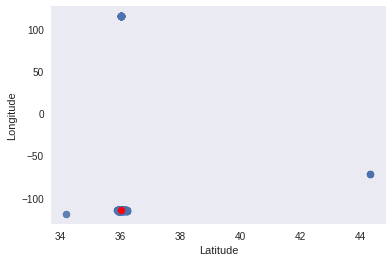

In [33]:
visualize_all_points(henderson_reviews).show()

### Naive K means Outlier Removal
This approachis stupid. But time was spent devoloping it so feel free to check it out at our <a href="http://htmlpreview.github.io/?https://github.com/smwade/Yelp-Prediction/blob/master/machine_learning/Auxilery.html#Naive-K-means-Outlier-Removal">auxilery</a>.

### Cleaning Outliers with EllipticEnvelope

Below you can see we clean our data with the "EllipticEnvelope". This enables us to remove all those weird blips that are thousands of miles from Hendreson.

In [34]:
def clean_reviewer_average_radius_with_EllipticEnvelope(reviews):
    """A function to clean outliers using the EllipticEnvelope Method"""
    good_points = {}
    classifier = EllipticEnvelope(contamination=0.005)
    centers, user_ids = get_all_centers_as_array(reviews)
    classifier.fit(centers)
    inlier_indexes = np.where(classifier.predict(centers) != -1)
    user_ids = np.array(user_ids)[inlier_indexes]
    for i, user_id in enumerate(user_ids):
        good_points[user_id] = reviews[user_id]
    return good_points

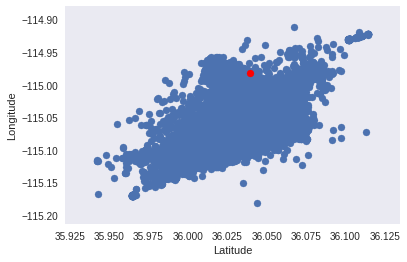

In [35]:
EllipticEnvelope_cleaned = clean_reviewer_average_radius_with_EllipticEnvelope(henderson_reviews)
visualize_centers(EllipticEnvelope_cleaned).show()

### Random Forest for Anomaly Detection (Isolation Forest)


Below you can see we clean our data with the "IsolationForest". This enables us to remove all those weird blips that are thousands of miles from Hendreson.

In [36]:
def clean_reviewer_average_radius_with_IsolationForest(reviews):
    rng = np.random.RandomState(42)
    good_points = {}
    classifier = IsolationForest(max_samples=1500, random_state=rng, contamination=0.005, n_jobs=-1)
    centers, user_ids = get_all_centers_as_array(reviews)
    classifier.fit(centers)
    des_on = classifier.decision_function(centers)
    #Within four standard deviations of the decision_function
    inlier_indexes = np.where(abs(des_on - np.mean(des_on))  < 4*np.std(des_on))
    user_ids = np.array(user_ids)[inlier_indexes]
    for i, user_id in enumerate(user_ids):
        good_points[user_id] = reviews[user_id]
    return good_points

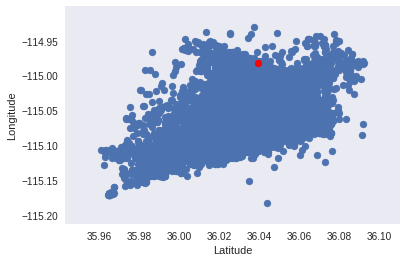

In [37]:
IsolationForest_cleaned = clean_reviewer_average_radius_with_IsolationForest(henderson_reviews)
visualize_centers(IsolationForest_cleaned).show()

As you can see the latter method includes a bit more points futher from the "center of henderson" (That that red dot) It is probably a better representation of all the reviews in Henderson. This is likely an issue cause by our hyper-parameter choices (one of them is what percentage of our data ar outliers) and the fact that the former method can fit much more exactly (it's not based on dictance from a point, but rather an (as the name might suggest elipse). 

## Calculating Radi
We've done alot with Henderson, so we will use Phoenix in this section, to make sure we don't limit our selection by a single city. 

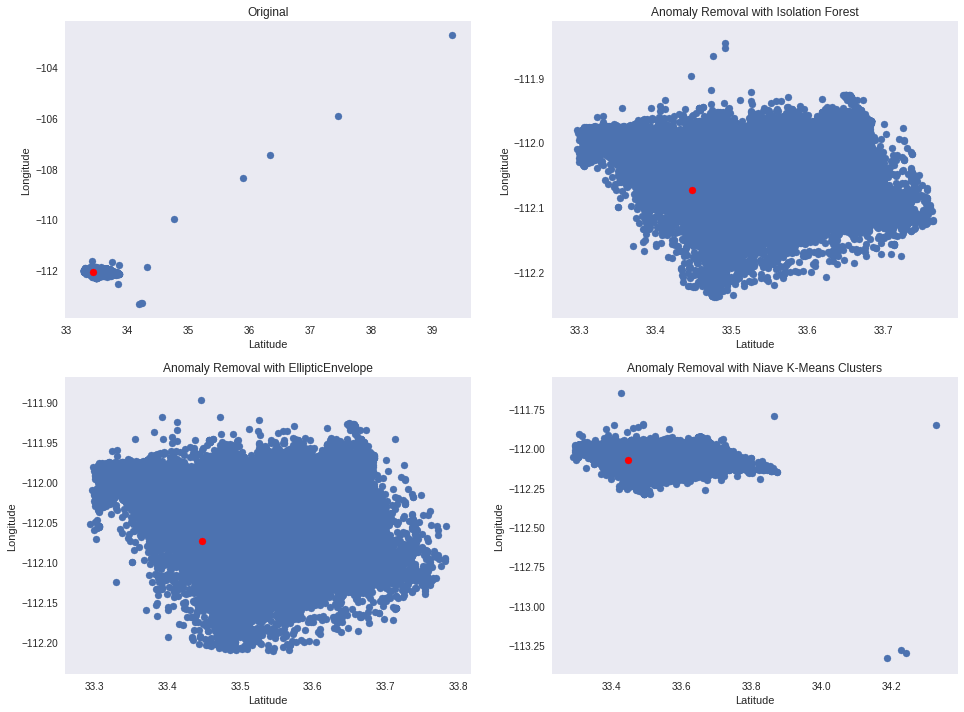

Naive K-Means Clusters predicted a radius of: 8.9329
Elliptic Envelope predicted a radius of: 8.9421
Isolation Forest predicted a radius of: 8.9380


In [22]:
phoenix_reviews = get_all_reviews_by_user_for_city("Phoenix")

plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
visualize_centers(phoenix_reviews, (33.448, -112.074)).title("Original")
plt.subplot(2, 2, 2)
visualize_centers(clean_reviewer_average_radius_with_IsolationForest(phoenix_reviews), (33.448, -112.074)).title("Anomaly Removal with Isolation Forest")
plt.subplot(2, 2, 3)
visualize_centers(clean_reviewer_average_radius_with_EllipticEnvelope(phoenix_reviews), (33.448, -112.074)).title("Anomaly Removal with EllipticEnvelope")
plt.subplot(2, 2, 4)
visualize_centers(clean_reviewer_average_radius_with_get_clusters(phoenix_reviews), (33.448, -112.074)).title("Anomaly Removal with Niave K-Means Clusters")

plt.show()

print("Naive K-Means Clusters predicted a radius of: {0:.4f}".format(get_radius_from_review_centers_dict(clean_reviewer_average_radius_with_get_clusters(phoenix_reviews))))
print("Elliptic Envelope predicted a radius of: {0:.4f}".format(get_radius_from_review_centers_dict(clean_reviewer_average_radius_with_EllipticEnvelope(phoenix_reviews))))
print("Isolation Forest predicted a radius of: {0:.4f}".format(get_radius_from_review_centers_dict(clean_reviewer_average_radius_with_IsolationForest(phoenix_reviews))))

## Web App



## Conclusion
<hr>

By applying these machine learning we were able to accomplish a successful baseline for our 3 project goals. Topic modeling has shown the competitiveness between companies. Using k-means and random forests we performed anomaly detection on city data. Lastly we applied many different models to sentiment analysis.
